In [1]:
#Instalamos Keras 3.3.3
!pip install --upgrade keras
#Instalamos Keras NLP
!pip install --upgrade keras-nlp


  Using cached keras_nlp-0.12.1-py3-none-any.whl (570 kB)
  Using cached keras_core-0.1.7-py3-none-any.whl (950 kB)
  Using cached tensorflow_text-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninst

**En este punto he subido el fichero output_compact.csv creado por Daniel.**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import pandas as pd
# Cargamos el fichero creado por Daniel en un dataframe
df = pd.read_csv('/content/gdrive/MyDrive/TFM - KSCHOOL - DataScience/Recursos/output_subset.csv')
df.tail()

,natural_language_query,metrics,dimensions,start_date,end_date,dimensionFilter,metricFilter
99995,Dime el porcentaje de conversiones de usuario ...,userConversionRate,streamName,2023-01-01,2023-12-31,NaN,NaN
99996,Muestra el total de compradores donde modelo d...,totalPurchasers,NaN,2021-01-01,2022-12-31,"{""filter"": {""fieldName"": ""deviceModel"", ""field...",NaN
99997,Discute los artículos vistos incluidos en la p...,itemsViewedInPromotion,itemCategory,2022-01-01,2024-12-31,"{""filter"": {""fieldName"": ""firstUserDefaultChan...",NaN
99998,Explica la duración promedio de la sesión y el...,averageSessionDuration;averagePurchaseRevenue,unifiedPageScreen,2021-01-01,2021-12-31,NaN,NaN
99999,Expóname la conversión de comprador que sea pr...,purchaserConversionRate,NaN,2017-07-01,2024-07-31,"{""filter"": {""fieldName"": ""firstUserMedium"", ""f...",NaN


Procesamos el texto

In [5]:
import re
import json
print(df.dtypes)
df['metrics'] = df['metrics'].apply(lambda x: re.sub(';', ' ', x))
df['dimensions'] = df['dimensions'].fillna('none')
df['dimensions'] = df['dimensions'].apply(lambda x: re.sub(';', ' ', x))
df['dimensionFilter'] = df['dimensionFilter'].fillna('none')
df['dimensionFilter'] = df['dimensionFilter'].astype('str')


def formatFilter(x):
  if x != 'none':
    res = json.loads(x)
    return 'filteredBy ' + res['filter']['fieldName'] + ' ' + res['filter']['fieldFilter']['match'] + ' ' + str(res['filter']['fieldFilter']['value'])
  else:
    return 'filteredBy none none none'

df['dimensionFilter'] = df['dimensionFilter'].apply(formatFilter)

df['target'] = 'get ' + df['metrics'] + ' segmentedBy ' + df['dimensions'] + ' from ' + df['start_date'] + ' to ' + df['end_date'] + ' ' + df['dimensionFilter']

df.head()


natural_language_query     object
metrics                    object
dimensions                 object
start_date                 object
end_date                   object
dimensionFilter            object
metricFilter              float64
dtype: object


,natural_language_query,metrics,dimensions,start_date,end_date,dimensionFilter,metricFilter,target
0,Manifiesta la tasa de clics de la lista de art...,itemListClickThroughRate active1DayUsers,firstUserSourcePlatform,119daysAgo,today,filteredBy isoWeek ENDS_WITH raw,NaN,get itemListClickThroughRate active1DayUsers s...
1,Aclara el porcentaje de rebote por id de promo...,bounceRate,itemPromotionId,2024-01-01,2024-12-31,filteredBy none none none,NaN,get bounceRate segmentedBy itemPromotionId fro...
2,Manifiéstame el recuento de eventos por usuari...,eventCountPerUser,hostName,2023-08-01,2023-09-30,filteredBy defaultChannelGroup EQUALS 191,NaN,get eventCountPerUser segmentedBy hostName fro...
3,Comunica el recuento de eventos por usuario y ...,eventCountPerUser itemsClickedInList,none,2011-01-01,2017-12-31,filteredBy none none none,NaN,get eventCountPerUser itemsClickedInList segme...
4,Exprésame los usuarios activos y los usuarios ...,activeUsers newUsers,none,3650daysAgo,today,filteredBy deviceModel EXACT thumb,NaN,get activeUsers newUsers segmentedBy none from...


Para que no existan separadores y podamos tomar los nombres por separado podemos especificarlo de la siguiente manera:

screenPageViewsPerSession||2019-11-26|2019-11-26|firstUserPrimaryChannelGroup;BEGINS_WITH;curiosity|

m:screenPageViewsPerSession di:2019-11-26 de:2019-11-26 f:firstUserPrimaryChannelGroup fc:BEGINS_WITH fm:curiosity

m metric
d dimension
di date init
de date end
f filter
fc filter condition
fm filter match
(no he pensado que pasa si hay varias condiciones)

In [6]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z0-9- ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['natural_language_query'] = df['natural_language_query'].apply(lambda row: clean_text(row))
df['target'] = df['target'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,natural_language_query,metrics,dimensions,start_date,end_date,dimensionFilter,metricFilter,target
0,manifiesta la tasa de clics de la lista de art...,itemListClickThroughRate active1DayUsers,firstUserSourcePlatform,119daysAgo,today,filteredBy isoWeek ENDS_WITH raw,NaN,[start] get itemlistclickthroughrate active1da...
1,aclara el porcentaje de rebote por id de promo...,bounceRate,itemPromotionId,2024-01-01,2024-12-31,filteredBy none none none,NaN,[start] get bouncerate segmentedby itempromoti...
2,manifiestame el recuento de eventos por usuari...,eventCountPerUser,hostName,2023-08-01,2023-09-30,filteredBy defaultChannelGroup EQUALS 191,NaN,[start] get eventcountperuser segmentedby host...
3,comunica el recuento de eventos por usuario y ...,eventCountPerUser itemsClickedInList,none,2011-01-01,2017-12-31,filteredBy none none none,NaN,[start] get eventcountperuser itemsclickedinli...
4,expresame los usuarios activos y los usuarios ...,activeUsers newUsers,none,3650daysAgo,today,filteredBy deviceModel EXACT thumb,NaN,[start] get activeusers newusers segmentedby n...


The next step is to scan the phrases and determine the maximum length of the English phrases and then of the French phrases. These lengths will determine the lengths of the sequences input to and output from the model:

In [7]:
nl = df['natural_language_query']
api = df['target']

nl_max_len = max(len(line.split()) for line in nl)
api_max_len = max(len(line.split()) for line in api)
sequence_len = max(nl_max_len, api_max_len)

print(f'Max phrase length (NL): {nl_max_len}')
print(f'Max phrase length (API): {api_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (NL): 59
Max phrase length (API): 15
Sequence length: 59


Now fit one Tokenizer to the English phrases and another Tokenizer to their French equivalents, and generate padded sequences for all the phrases:

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nl_tokenizer = Tokenizer()
nl_tokenizer.fit_on_texts(nl)
nl_sequences = nl_tokenizer.texts_to_sequences(nl)
nl_x = pad_sequences(nl_sequences, maxlen=sequence_len, padding='post')

api_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
api_tokenizer.fit_on_texts(api)
api_sequences = api_tokenizer.texts_to_sequences(api)
api_y = pad_sequences(api_sequences, maxlen=sequence_len + 1, padding='post')

Compute the vocabulary sizes from the Tokenizer instances:

In [9]:
nl_vocab_size = len(nl_tokenizer.word_index) + 1
api_vocab_size = len(api_tokenizer.word_index) + 1

print(f'Vocabulary size (NL): {nl_vocab_size}')
print(f'Vocabulary size (API): {api_vocab_size}')

Vocabulary size (NL): 5625
Vocabulary size (API): 5910


Finally, create the features and the labels the model will be trained with. The features are the padded NL sequences and the padded API sequences minus the [end] tokens. The labels are the padded French sequences minus the [start] tokens. Package the features in a dictionary so they can be input to a model that accepts multiple inputs.

In [10]:
inputs = { 'encoder_input': nl_x, 'decoder_input': api_y[:, :-1] }
outputs = api_y[:, 1:]

# Build and train the model

Now use Keras's functional API to define a model that includes a transformer encoder and a transformer decoder. The model accepts two inputs: padded English sequences for the encoder, and padded French sequences for the decoder. The output from the decoder is fed to a softmax output layer for classification.

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 16
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(nl_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(api_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(api_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ encoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ token_and_position_embedding      │ (None, None, 256)            │         1,455,104 │ encoder_input[0][0]       
│ (TokenAndPositionEmbedding)       │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ decoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ transformer_encoder               │ (None, None, 256)            │           395,776 │ token_and_position_embeddi
│ (TransformerEncoder)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ functional_1 (Functional)         │ (None, None, 5910)           │         3,706,390 │ decoder_input[0][0],      
│                                   │                              │                   │ transformer_encoder[0][0] 
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 5,557,270 (21.20 MB)

 Trainable params: 5,557,270 (21.20 MB)

 Non-trainable params: 0 (0.00 B)

Train the model, and use an EarlyStopping callback to end training if the validation accuracy fails to improve for three consecutive epochs:

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 119s 19ms/step - accuracy: 0.2310 - loss: 1.1005 - val_accuracy: 0.2772 - val_loss: 0.1180
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 77s 19ms/step - accuracy: 0.2816 - loss: 0.0922 - val_accuracy: 0.2784 - val_loss: 0.0386
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 84s 20ms/step - accuracy: 0.2950 - loss: 0.0295 - val_accuracy: 0.2813 - val_loss: 0.0336
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.3386 - loss: 0.0271 - val_accuracy: 0.3027 - val_loss: 0.0160
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.3537 - loss: 0.0171 - val_accuracy: 0.4890 - val_loss: 0.0092
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.4073 - loss: 0.0125 - val_accuracy: 0.6868 - val_loss: 0.0127
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.5329 - loss: 0.0164 - val_accuracy: 0.5665 - val_loss: 0.0124
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 83s 19ms/step - accuracy: 0.5058 - loss: 0.0

[]

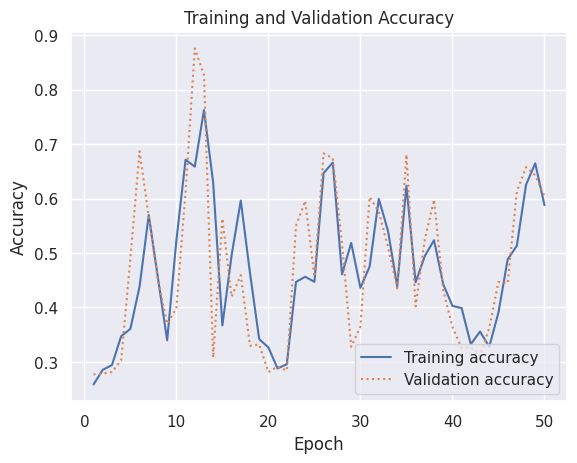

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [14]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]

        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break

    return decoded_text[8:-6] # Remove [start] and [end] tokens

api_vocab = api_tokenizer.word_index
api_index_lookup = dict(zip(range(len(api_vocab)), api_vocab))
texts = nl[40000:40010].values

for text in texts:
    translated = translate_text(text, model, nl_tokenizer, api_tokenizer, api_index_lookup, sequence_len)
    print(f'{text} => {translated}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.

informa el porcentaje de sesiones con conversiones por variante del articulo durante el 15 de enero de 2011 => get sessionconversionrate segmentedby itemvariant from 2011 01 15 to 2011 01 15 filteredby none none none
discute la tasa de participacion y el porcentaje de sesiones con conversiones del 14 de diciembre de 2022 => get engagementrate sessionconversionrate segmentedby none from 2022 12 14 to 2022 12 14 filteredby none none none
narra los usuarios activos durante los ultimos 28dias de termino manual de la sesion que sea menor o igual que 421 en agosto 2007 => get active28dayusers segmentedby none from 2007 08 01 to 2007 08 31 filteredby sessionmanualterm lessthanorequalto 421
planteame las compras de comercio electronico de ayer => get ecommercepurchases segmentedby none from yesterday to yesterday filteredby none none none
indica los usuarios nuevos restringido a porcentaje de desplazamiento que sea mayor o igual que 28 entre 2014 y 2019 => get newusers segmentedby none from 20

In [18]:
traduccion = translate_text("Dime las sesiones del año 2020 del dispositivo que es mobile", model, nl_tokenizer, api_tokenizer, api_index_lookup, sequence_len)

In [19]:
traduccion

'get sessions segmentedby none from 2020 01 01 to 2020 12 31 filteredby none none none'

print()

In [21]:
model.save('/content/gdrive/MyDrive/TFM - KSCHOOL - DataScience/Recursos/modelo.keras')

In [ ]:
import keras as keras
model2 = keras.models.load_model('modelo.keras')

# Other model (LSTM)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

np.random.seed(42)
tf.random.set_seed(42)

model_lstm = Sequential()
model_lstm.add(Embedding(nl_vocab_size, 256, input_length=nl_max_len, mask_zero=True))
model_lstm.add(LSTM(256))
model_lstm.add(RepeatVector(api_max_len))
model_lstm.add(LSTM(256, return_sequences=True))
model_lstm.add(Dropout(0.4))
model_lstm.add(TimeDistributed(Dense(api_vocab_size, activation='softmax')))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary(line_length=100)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                      │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm (LSTM)                                │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_1 (LSTM)                              │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_14 (Dropout)                       │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ time_distributed (TimeDistributed)         │ ?                               │       0 (unbuilt) │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model_lstm.fit(nl_x, api_y, epochs=50, batch_size=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(50, 60), output.shape=(50, 15, 5910)